In [1]:
from eda_import import *

In [2]:
df_manifest = pd.read_csv('./metadata/LATEST_MANIFEST.final.tsv.gz', low_memory=False, sep='\t', compression='gzip')

In [3]:
df_expr = pd.read_csv('./results_data/RPKMS.csv.gz', compression='gzip')

In [4]:
df_count = df_expr\
    .groupby(['disease', 'sstype'])\
    .count()['analysis_id']\
    .reset_index()\
    .rename(columns={'analysis_id': 'count'})\
    .pivot(index='disease', columns='sstype', values='count')\
    .fillna(0)

In [5]:
ndf = df_count.merge(df_manifest[['disease', 'disease_name']].drop_duplicates(), left_index=True, right_on='disease')
ndf['handy_disease_names'] = ndf.apply(lambda x: '{0}, {1}'.format(
        x.disease, ' '.join([_.capitalize() for _ in x.disease_name.split()])), axis=1)
# ndf.set_index(ndf['handy_disease_names'], inplace=True)
ndf.set_index(ndf['disease'], inplace=True)

In [6]:
ndf['total'] = ndf['normal'] + ndf['tumour']
ndf.head(3)

,normal,tumour,disease,disease_name,handy_disease_names,total
disease,,,,,,
ACC,0.0,79.0,ACC,ADRENOCORTICAL CARCINOMA,"ACC, Adrenocortical Carcinoma",79.0
BLCA,19.0,414.0,BLCA,BLADDER UROTHELIAL CARCINOMA,"BLCA, Bladder Urothelial Carcinoma",433.0
BRCA,114.0,1142.0,BRCA,BREAST INVASIVE CARCINOMA,"BRCA, Breast Invasive Carcinoma",1256.0


In [7]:
bin_width = 0.5

0.21764705882352942 Sufficient normal
0.5823529411764706 Insufficient normal
0.8647058823529412 No normal


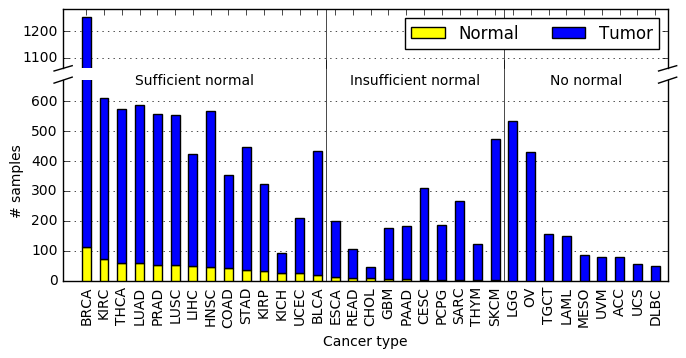

In [8]:
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

fig = plt.figure(figsize=(7.8, 3.5))
nrows = 12
ratio = 1 / (1 + 3) # meaning the first subplot is 1/3 height of the second one
gs = gridspec.GridSpec(nrows, 1, hspace=1)
ax1 = fig.add_subplot(gs[:int(nrows * ratio), :])
ax2 = fig.add_subplot(gs[int(nrows * ratio):,:])

odf = ndf.rename(columns={'normal': 'Normal', 'tumour': 'Tumor'})
# odf.sort_values(['Normal', 'Tumor'], ascending=[False, False])[['Normal', 'Tumor']].plot.bar(
#     ax=ax1, stacked=True, zorder=3, color=['blue', 'red'])
# odf.sort_values(['Normal', 'Tumor'], ascending=[False, False])[['Normal', 'Tumor']].plot.bar(
#     ax=ax2, stacked=True, zorder=3, color=['blue', 'red'])
odf.sort_values(['Normal', 'Tumor'], ascending=[False, False])[['Normal', 'Tumor']].plot.bar(
    ax=ax1, stacked=True, zorder=3, color=['yellow', 'blue'])
odf.sort_values(['Normal', 'Tumor'], ascending=[False, False])[['Normal', 'Tumor']].plot.bar(
    ax=ax2, stacked=True, zorder=3, color=['yellow', 'blue'])

ylim_max = 670
ax2.set_ylim(0, 670)  # most of the data
ax1.set_yticks(np.arange(1000, 1400, 100))
ax1.set_ylim(1060,1060 +  ylim_max * ratio / (1 - ratio))  # outliers only

ax2.legend().set_visible(False)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.set_xlabel('')
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.set_xlabel('Cancer type')
ax2.set_ylabel('# samples')
ax1.yaxis.grid(zorder=0)
ax2.yaxis.grid(zorder=0)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(flip(handles, 2), flip(labels, 2), loc='upper right', ncol=2)

scaler = 1 / ratio - 1
ax1.plot((-d, +d), (-d * scaler, d * scaler), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d * scaler, d * scaler), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


xlim = ax1.get_xlim()
# patch some space to both side
nxlim = [xlim[0] - 0.8, xlim[1] + 0.2]
nxlim_len = nxlim[1] - nxlim[0]

cf_xs = []
for cf_dise in ['BLCA', 'SKCM']:
    dise_idx = np.where(odf.sort_values('Normal', ascending = False).index.values == cf_dise)[0][0]
    cutoff_x = (ax2.patches[dise_idx + 1].get_x() + ax2.patches[dise_idx].get_x() + bin_width) / 2
    cf_x = (cutoff_x - nxlim[0]) / nxlim_len
    ax1.plot([cf_x, cf_x], [0, 1],    '-', color='black', lw=0.5, transform=ax1.transAxes, clip_on=False)
    ax2.plot([cf_x, cf_x], [0, 1.1], '-', color='black', lw=0.5, transform=ax2.transAxes, clip_on=False)  
    cf_xs.append(cf_x)

txt_cf_xs = np.array([0, *cf_xs, 1])
txt_cf_xs = (txt_cf_xs[:-1] + txt_cf_xs[1:]) / 2

# draw cutoff lines that cross the space between two subplots
for txt_cf_x, text in zip(
            txt_cf_xs,
            ['Sufficient normal', 'Insufficient normal', 'No normal']): # cf: cutoff
    print(txt_cf_x, text)
    ax2.text(txt_cf_x, 1, text, ha='center', va='center', transform=ax2.transAxes, clip_on=False)

for _ in [ax1, ax2]:
    _.set_xlim(nxlim)
# plt.savefig('./figs/sample_counts.jpg', dpi=500, bbox_inches='tight')